In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpmig
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

/Users/nguyen.vo.int/Downloads/brain-tumor-classification-main/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
tf.keras.utils.set_random_seed(42)

In [3]:
import kagglehub

# Download latest version
IMAGE_PATH = kagglehub.dataset_download("fernando2rad/brain-tumor-mri-images-44c")

/Users/nguyen.vo.int/Downloads/brain-tumor-classification-main/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(IMAGE_PATH)

There are 44 directories and 0 images in '/Users/nguyen.vo.int/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1'.
There are 0 directories and 17 images in '/Users/nguyen.vo.int/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1/Granuloma T2'.
There are 0 directories and 171 images in '/Users/nguyen.vo.int/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1/Astrocitoma T2'.
There are 0 directories and 233 images in '/Users/nguyen.vo.int/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1/Meningioma T2'.
There are 0 directories and 67 images in '/Users/nguyen.vo.int/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1/Meduloblastoma T1C+'.
There are 0 directories and 112 images in '/Users/nguyen.vo.int/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1/Carcinoma T1C+'.
There are 0 directories and 104 images in '/Users/nguyen.vo.int/.cac

In [6]:
# set some hyperparams
BATCH_SIZE = 32
IMAGE_HEIGHT = 228
IMAGE_WIDTH = 228

In [7]:
# create tf dataset from images with their correspoing labels
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                        IMAGE_PATH,
                        validation_split=0.2,
                        subset="training",
                        seed=42,
                        image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                        batch_size=BATCH_SIZE
)

Found 4478 files belonging to 44 classes.
Using 3583 files for training.


In [8]:
# and a valid set to grab some idea about model
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
                        IMAGE_PATH,
                        validation_split=0.2,
                        subset="validation",
                        seed=42,
                        image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                        batch_size=BATCH_SIZE
    )

Found 4478 files belonging to 44 classes.
Using 895 files for validation.


In [9]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 228, 228, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2024-10-20 16:03:39.912767: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


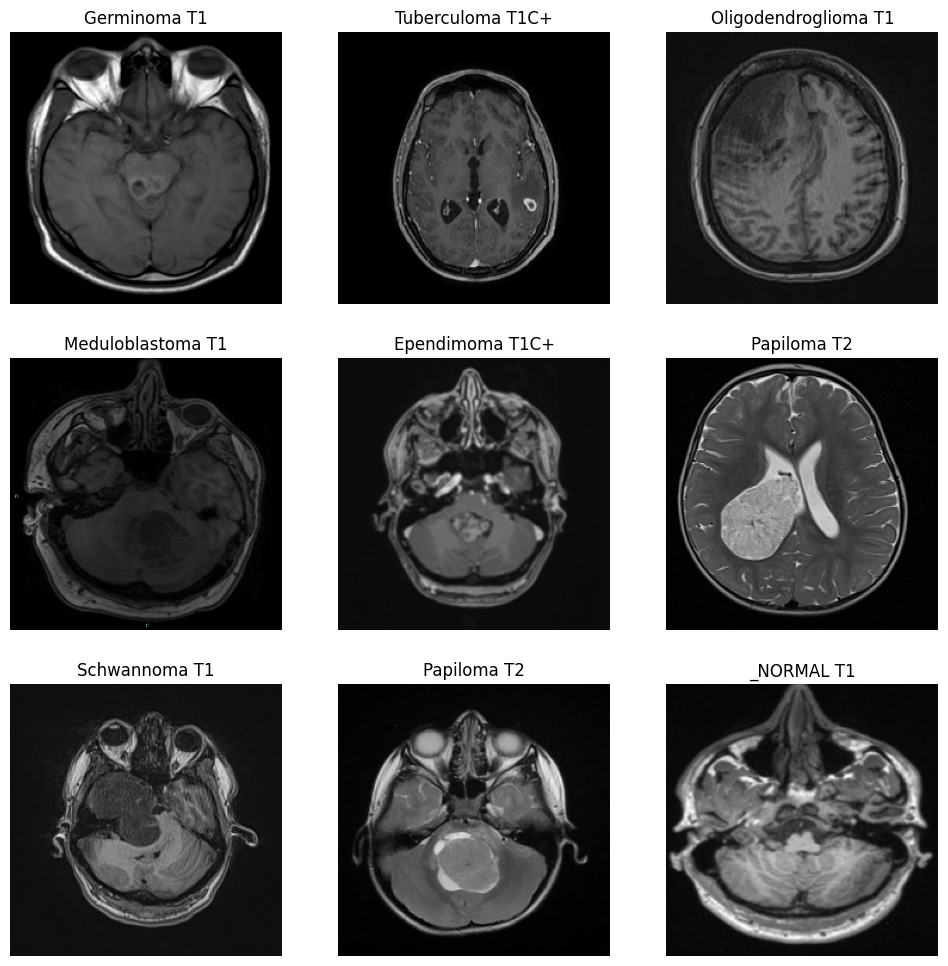

In [10]:
# display some images
classes = train_ds.class_names

plt.figure(figsize=(12,12))

for images, labels in train_ds.take(1): # every batch has 32 images, we take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [11]:
# try some data augmentation and normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(tf.data.AUTOTUNE)

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.4)
])

2024-10-20 16:03:40.833272: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


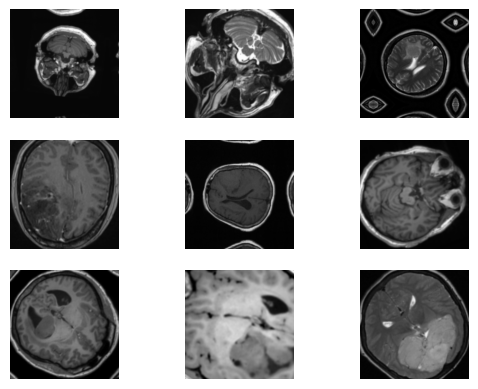

In [12]:
# display some augmented images on not normalized images
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_image[i].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

In [14]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)

x = Conv2D(128, kernel_size=3, activation="relu", padding="same")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Dropout(.2)(x)
x = Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten(name="flatten")(x)
outputs = Dense(44, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3)
chckpntng_pth = "best_checkpoint.weights.h5"  # Update the filename to include the extension
chckpntng = ModelCheckpoint(filepath=chckpntng_pth,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor="val_accuracy",
                             verbose=1
                             )

In [16]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy="mixed_float16")

In [17]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [18]:
model.compile(
    optimizer=Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(), # sparse_categorical_crossentropy if labels are **not** one hot encode
    metrics=["accuracy"])

In [19]:
history_ds = model.fit(train_ds, validation_data=valid_ds, batch_size=BATCH_SIZE, epochs=100, callbacks=[early_stopping, chckpntng])

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2071 - loss: 37.0193
Epoch 1: val_accuracy improved from -inf to 0.49162, saving model to best_checkpoint.weights.h5
112/112 ━━━━━━━━━━━━━━━━━━━━ 632s 6s/step - accuracy: 0.2083 - loss: 36.7902 - val_accuracy: 0.4916 - val_loss: 2.0543
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6722 - loss: 1.2354
Epoch 2: val_accuracy improved from 0.49162 to 0.63687, saving model to best_checkpoint.weights.h5
112/112 ━━━━━━━━━━━━━━━━━━━━ 655s 6s/step - accuracy: 0.6725 - loss: 1.2342 - val_accuracy: 0.6369 - val_loss: 1.4338
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8513 - loss: 0.5381
Epoch 3: val_accuracy improved from 0.63687 to 0.74972, saving model to best_checkpoint.weights.h5
112/112 ━━━━━━━━━━━━━━━━━━━━ 664s 6s/step - accuracy: 0.8514 - loss: 0.5377 - val_accuracy: 0.7497 - val_loss: 1.2615
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9203 - loss: 0.2910
Epoch 